The Black-Scholes model (BSM) is a widespread option-pricing model which has been pivotal to the growth and success of financial engineering. The model estimates the theoretical value of European call and put options based on other financial instruments. There are 5 parameters for the BSM: the strike price of an option, the current stock price, the time to expiration, the risk-free rate, and the volatility.

Assumptions

1. The options being traded are European style
2. The stock price behaviour corresponds to the log-normal distribution with a constant μ and σ
3. There are no transaction costs or taxes. All securities are perfectly divisible
4. There are no dividends on the stock during the life of the option
5. There are no riskless arbitrage opportunities
6. Investors can borrow or lend at the same risk-free rate of interest

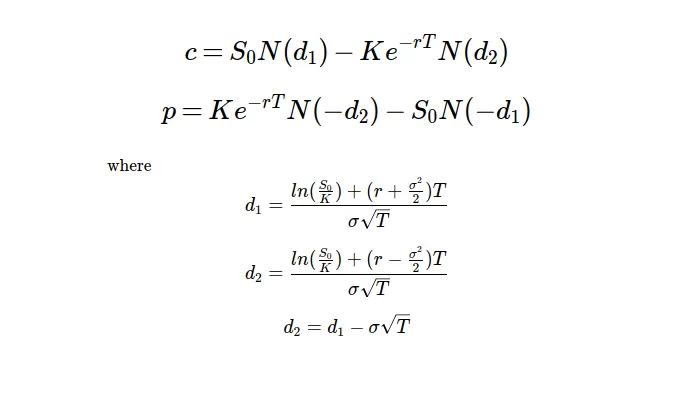

where,

c: call price of option

p: put price of option

N: CDF (cumulative distribution function) of the normal distribution

S₀: Initial stock price of asset at time of trade

K: Strike price

r: risk-free interest rate

t: time to maturity

σ: Volatility of the asset

Reference: Fundamentals of Futures and Options Markets (Ninth Edition) by John Hull

In [ ]:
from math import sqrt, log, pow, erf, e
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import norm

In [ ]:
def standard_normal_cdf(x):
    return 0.5 * (1 + erf(x / sqrt(2)))

def d1(S, K, t, r, vol):
    numerator = log(S/K) + (r + pow(vol, 2)/2) * t
    denominator = vol * sqrt(t)
    return numerator / denominator

def d2(S, K, t, r, vol):
    return d1(S, K, t, r, vol) - vol * sqrt(t)

def call_price(S, K, t, r, vol):
    Nd1 = standard_normal_cdf(d1(S, K, t, r, vol))
    Nd2 = standard_normal_cdf(d2(S, K, t, r, vol))
    return Nd1 * S - Nd2 * K * pow(e, -1 * r * t)

def put_price(S, K, t, r, vol):
    Nd1 = standard_normal_cdf(- 1 * d1(S, K, t, r, vol))
    Nd2 = standard_normal_cdf(- 1 * d2(S, K, t, r, vol))
    return Nd2 * K * pow(e, -1 * r * t) - S * Nd1

Using the YFinance API, we can find the option dates for a specific ticker. It generates all possible expiry dates for options of the underlying asset.

In [ ]:
ticker = 'TSLA'
option = yf.Ticker(ticker)
option.options

('2025-09-05',
 '2025-09-12',
 '2025-09-19',
 '2025-09-26',
 '2025-10-03',
 '2025-10-10',
 '2025-10-17',
 '2025-11-21',
 '2025-12-19',
 '2026-01-16',
 '2026-02-20',
 '2026-03-20',
 '2026-04-17',
 '2026-05-15',
 '2026-06-18',
 '2026-07-17',
 '2026-08-21',
 '2026-09-18',
 '2026-12-18',
 '2027-01-15',
 '2027-06-17',
 '2027-12-17')

Inputting one of the dates above into the date variable and running the code below will fetch the call and put option chains for the chosen asset.

In [ ]:
# Picking a date from the above
date = '2025-09-12'

def fetch_options_data(ticker_symbol, date):
    ticker = yf.Ticker(ticker_symbol)
    options_data = ticker.option_chain(date)
    return options_data.calls, options_data.puts

calls, puts = fetch_options_data(ticker, date)
calls = pd.DataFrame(calls)
calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,TSLA250912C00070000,2025-08-28 19:27:09+00:00,70.0,276.00,262.35,268.20,0.000000,0.000000,NaN,1,4.890629,True,REGULAR,USD
1,TSLA250912C00080000,2025-09-03 15:06:23+00:00,80.0,261.84,253.50,258.20,12.690002,5.093318,1.0,5,4.804691,True,REGULAR,USD
2,TSLA250912C00100000,2025-08-28 17:58:20+00:00,100.0,245.50,233.30,238.05,0.000000,0.000000,350.0,214,4.007817,True,REGULAR,USD
3,TSLA250912C00130000,2025-08-06 17:38:52+00:00,130.0,190.00,202.70,207.95,0.000000,0.000000,NaN,1,3.052737,True,REGULAR,USD
4,TSLA250912C00135000,2025-09-02 13:32:44+00:00,135.0,192.60,197.80,202.95,0.000000,0.000000,12.0,8,2.961917,True,REGULAR,USD


For the Black Scholes formula, we need 5 inputs: S, K, t, r, and σ. From the above dataframe we can only extract the strike values (K) — so we need to get the four other data input values.

For the r value, I chose to use the 10 year US treasury rate.

The volatility calculated in this example is the annualized volatility, which is determined by calculating the average returns of the stock price and multiplying it by the square root of 252 (the number of trading days in per year from 1986 to 2022).

In [ ]:
def get_current_stock_price(ticker_symbol):
    stock = yf.Ticker(ticker_symbol)
    current_price = stock.history(period='1d')['Close'].iloc[-1]
    return current_price

def get_10yr_treasury_rate():
    # 10 year treasury ticker symbol
    treasury_ticker = "^TNX"

    now = datetime.now()
    ten_years_ago = now.replace(year=now.year - 10)

    treasury_data = yf.download(treasury_ticker, start=ten_years_ago, end=now)
    last_yield = treasury_data['Close'].iloc[-1]
    return last_yield

def get_date(date_str):
    # Assuming the date string is in the format 'YYYY-MM-DD'
    date_object = datetime.strptime(date_str, '%Y-%m-%d')

    current_date = datetime.now()
    years_difference = (date_object - current_date).days / 365.25
    return years_difference

def calculate_volatility(ticker):

    today = datetime.now()
    one_year_ago = today.replace(year=today.year-1)
    data = yf.download(ticker, start=one_year_ago, end=today)

    # Calculate daily returns
    # Use 'Close' instead of 'Adj Close' if 'Adj Close' is not available
    if 'Adj Close' in data.columns:
        data['Daily_Return'] = data['Adj Close'].pct_change()
    else:
        data['Daily_Return'] = data['Close'].pct_change()

    # std of daily returns
    daily_volatility = data['Daily_Return'].std()
    annualized_volatility = daily_volatility * np.sqrt(252)

    return annualized_volatility

In [ ]:
S = get_current_stock_price(ticker)
r = get_10yr_treasury_rate()
t = get_date(date)
vol = calculate_volatility(ticker)

# Converting r to percentage
r = r / 100

print(f"\nRiskfree rate: {r}")
print(f"\nYears difference: {t}")
print(f"The current stock price of {ticker} is: {S}")

/tmp/ipython-input-891736206.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  treasury_data = yf.download(treasury_ticker, start=ten_years_ago, end=now)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-891736206.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=one_year_ago, end=today)
[*********************100%***********************]  1 of 1 completed


Riskfree rate: Ticker
^TNX    0.04211
Name: 2025-09-03 00:00:00, dtype: float64

Years difference: 0.02190280629705681
The current stock price of TSLA is: 334.0899963378906


Now, as we have all of our variables, we can calculate the BSM valuation for each option and add the valuation as a feature to our dataframe

In [ ]:
call_df = calls.copy()
columns_to_drop = ['contractSize', 'currency']
call_df.drop(columns=columns_to_drop, inplace=True)
call_df['bsmValuation'] = call_df.apply(lambda row: call_price(S, row['strike'], t, r, vol), axis=1)
call_df.head(50)

/tmp/ipython-input-203810975.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return 0.5 * (1 + erf(x / sqrt(2)))
/tmp/ipython-input-203810975.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return Nd1 * S - Nd2 * K * pow(e, -1 * r * t)


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,bsmValuation
0,TSLA250912C00070000,2025-08-28 19:27:09+00:00,70.0,276.00,262.35,268.20,0.000000,0.000000,NaN,1,4.890629,True,264.154529
1,TSLA250912C00080000,2025-09-03 15:06:23+00:00,80.0,261.84,253.50,258.20,12.690002,5.093318,1.0,5,4.804691,True,254.163748
2,TSLA250912C00100000,2025-08-28 17:58:20+00:00,100.0,245.50,233.30,238.05,0.000000,0.000000,350.0,214,4.007817,True,234.182187
3,TSLA250912C00130000,2025-08-06 17:38:52+00:00,130.0,190.00,202.70,207.95,0.000000,0.000000,NaN,1,3.052737,True,204.209844
4,TSLA250912C00135000,2025-09-02 13:32:44+00:00,135.0,192.60,197.80,202.95,0.000000,0.000000,12.0,8,2.961917,True,199.214453
5,TSLA250912C00140000,2025-09-02 14:28:21+00:00,140.0,191.06,192.45,198.00,0.000000,0.000000,9.0,10,2.791995,True,194.219063
6,TSLA250912C00145000,2025-08-13 16:13:46+00:00,145.0,196.95,188.60,193.10,0.000000,0.000000,1.0,1,2.913089,True,189.223672
7,TSLA250912C00150000,2025-09-02 17:02:11+00:00,150.0,180.42,182.05,188.05,0.000000,0.000000,4.0,63,2.518558,True,184.228282
8,TSLA250912C00155000,2025-08-22 17:30:44+00:00,155.0,183.34,177.90,183.20,0.000000,0.000000,1.0,1,2.610355,True,179.232891
9,TSLA250912C00160000,2025-08-20 16:33:16+00:00,160.0,162.05,172.10,178.05,0.000000,0.000000,NaN,1,2.344731,True,174.237501


# Measuring Sensitivity with the Greeks

The greeks are a set of symbols that assist in measuring different dimensions to the risk in an option position. The aim of a trader is to manage the greeks so that all the risks are acceptable.

Delta(Δ): The change in option’s premium for every $1 change in the underlying stock’s price.

Gamma(Γ): The change in the option’s delta (Δ) for every $1 change in the underlying stock price.

Theta(Θ): The change in the option’s premium for every day that passes, representing the time decay. Theta reflects the rate at which the option’s premium decreases over time.

Vega(ν): Change in the option’s premium for every 1% change in implied volatility. Vega measures the sensitivity of the option’s price to changes in the implied vol.

Rho(ρ): Change in the option’s premium for every 1% change in the risk-free rate. Rho measures the sensitivity of the option’s price to changes in the interest rate.

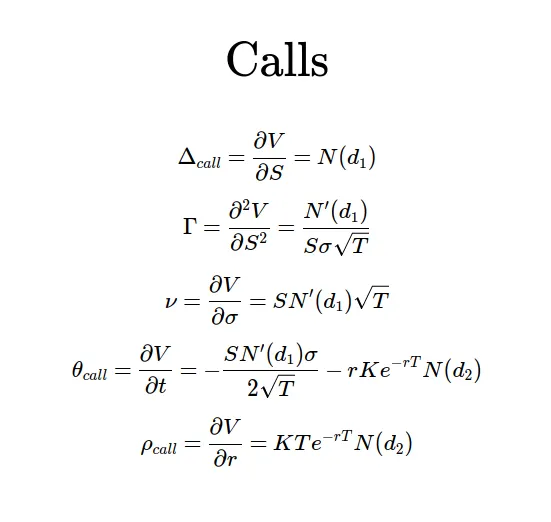

In [ ]:
# Call Options

def delta_call(S, K, t, r, vol):
    return norm.cdf(d1(S, K, t, r, vol))

def gamma_call(S, K, t, r, vol):
    numerator = norm.pdf(d1(S, K, t, r, vol))
    denominator = S * vol * sqrt(e)
    return numerator / denominator

def vega_call(S, K, t, r, vol):
    return S * norm.pdf(d1(S, K, t, r, vol)) * sqrt(t)

def theta_call(S, K, t, r, vol):
    numerator = S * norm.pdf(d1(S, K, t, r, vol)) * vol
    denominator = 2 * sqrt(t)
    return -1 * (numerator / denominator) - r * K * pow(e, -1 * r * t) * norm.cdf(d2(S, K, t, r, vol))

def rho_call(S, K, t, r, vol):
    return K * t * pow(e, -1 * r * t * norm.cdf(d2(S, K, t, r, vol)))

In [ ]:
greeks_df = call_df.copy()
greeks_df['delta'] = greeks_df.apply(lambda row: delta_call(S, row['strike'], t, r, vol), axis=1)
greeks_df['gamma'] = greeks_df.apply(lambda row: gamma_call(S, row['strike'], t, r, vol), axis=1)
greeks_df['vega'] = greeks_df.apply(lambda row: vega_call(S, row['strike'], t, r, vol), axis=1)
greeks_df['theta'] = greeks_df.apply(lambda row: theta_call(S, row['strike'], t, r, vol), axis=1)
greeks_df['rho'] = greeks_df.apply(lambda row: rho_call(S, row['strike'], t, r, vol), axis=1)

greeks_df.head(10)

/tmp/ipython-input-153656518.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return -1 * (numerator / denominator) - r * K * pow(e, -1 * r * t) * norm.cdf(d2(S, K, t, r, vol))
/tmp/ipython-input-153656518.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return K * t * pow(e, -1 * r * t * norm.cdf(d2(S, K, t, r, vol)))


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,bsmValuation,delta,gamma,vega,theta,rho
0,TSLA250912C00070000,2025-08-28 19:27:09+00:00,70.0,276.00,262.35,268.20,0.000000,0.000000,NaN,1,4.890629,True,264.154529,[1.0],[1.0442006289120362e-51],[2.0286459850365258e-47],-2.944982,1.531783
1,TSLA250912C00080000,2025-09-03 15:06:23+00:00,80.0,261.84,253.50,258.20,12.690002,5.093318,1.0,5,4.804691,True,254.163748,[1.0],[6.876384968600281e-44],[1.3359262934605653e-39],-3.365694,1.750609
2,TSLA250912C00100000,2025-08-28 17:58:20+00:00,100.0,245.50,233.30,238.05,0.000000,0.000000,350.0,214,4.007817,True,234.182187,[1.0],[2.2505266413529477e-32],[4.372264973595411e-28],-4.207118,2.188261
3,TSLA250912C00130000,2025-08-06 17:38:52+00:00,130.0,190.00,202.70,207.95,0.000000,0.000000,NaN,1,3.052737,True,204.209844,[1.0],[2.5666555694477e-21],[4.986432081885233e-17],-5.469253,2.844740
4,TSLA250912C00135000,2025-09-02 13:32:44+00:00,135.0,192.60,197.80,202.95,0.000000,0.000000,12.0,8,2.961917,True,199.214453,[1.0],[6.014922739987217e-20],[1.1685636389142493e-15],-5.679609,2.954153
5,TSLA250912C00140000,2025-09-02 14:28:21+00:00,140.0,191.06,192.45,198.00,0.000000,0.000000,9.0,10,2.791995,True,194.219063,[1.0],[1.1136753634538778e-18],[2.1636197031012545e-14],-5.889965,3.063566
6,TSLA250912C00145000,2025-08-13 16:13:46+00:00,145.0,196.95,188.60,193.10,0.000000,0.000000,1.0,1,2.913089,True,189.223672,[0.9999999999999992],[1.6632118756702547e-17],[3.231245031291553e-13],-6.100321,3.172979
7,TSLA250912C00150000,2025-09-02 17:02:11+00:00,150.0,180.42,182.05,188.05,0.000000,0.000000,4.0,63,2.518558,True,184.228282,[0.9999999999999897],[2.0405886732713396e-16],[3.964402916952885e-12],-6.310677,3.282392
8,TSLA250912C00155000,2025-08-22 17:30:44+00:00,155.0,183.34,177.90,183.20,0.000000,0.000000,1.0,1,2.610355,True,179.232891,[0.99999999999989],[2.090511833780787e-15],[4.0613923424748235e-11],-6.521033,3.391805
9,TSLA250912C00160000,2025-08-20 16:33:16+00:00,160.0,162.05,172.10,178.05,0.000000,0.000000,NaN,1,2.344731,True,174.237501,[0.999999999999006],[1.8144453470666837e-14],[3.5250575095230196e-10],-6.731389,3.501218


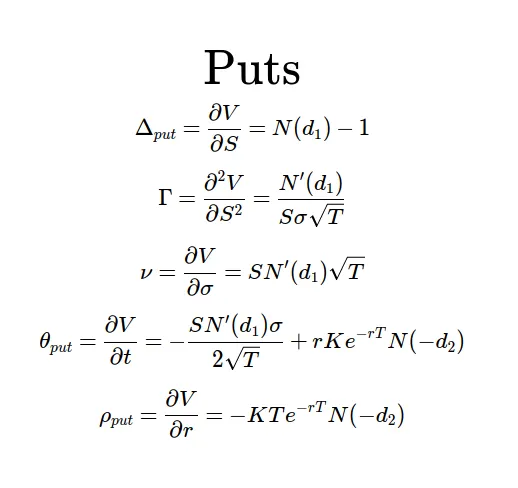

In [ ]:
# Put Options

def delta_put(S, K, t, r, vol):
    return norm.cdf(d1(S, K, t, r, vol)) - 1

def gamma_put(S, K, t, r, vol):
    numerator = norm.pdf(d1(S, K, t, r, vol))
    denominator = S * vol * sqrt(e)
    return numerator / denominator

def vega_put(S, K, t, r, vol):
    return S * norm.pdf(d1(S, K, t, r, vol)) * sqrt(t)

def theta_put(S, K, t, r, vol):
    numerator = S * norm.pdf(d1(S, K, t, r, vol)) * vol
    denominator = 2 * sqrt(t)
    return -1 * (numerator / denominator) + r * K * pow(e, -1 * r * t) * norm.cdf(-1 * d2(S, K, t, r, vol))

def rho_put(S, K, t, r, vol):
    return -1 * K * t * pow(e, -1 * r * t * norm.cdf(-1 * d2(S, K, t, r, vol)))

**Conclusion:**

The Black Scholes model is specifically designed for European options. In the case of American options, alternative models like the binomial option model become relevant. Similarly, for exotic options, techniques like **Monte Carlo simulation** can be effective.

# Applying ML to predict

1. Data Cleaning & Feature Engineering

Taking only the option contracts that have significant volume and open interest, with the last_trade_date as today. We'll also add some features like marketPrice and valuation for us to understand and predict the data better.

We can take the theoretical value from the BSM model, and compare it to the option's current market price (the midpoint between the bid and ask).


*   If the market price > theoretical value, the option is considered overvalued.
*   If the market price < theoretical value, the option is considered undervalued.

In [ ]:
greeks_df = greeks_df[(call_df['volume'] > 100) & (greeks_df['openInterest'] > 100) & (greeks_df['lastTradeDate'].dt.date == datetime.today().date())]
greeks_df['marketPrice'] = (greeks_df['bid'] + greeks_df['ask']) / 2
greeks_df['valuation'] = np.where(greeks_df['marketPrice'] < greeks_df['bsmValuation'], 'undervalued', 'overvalued')

greeks_df.head(50)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,bsmValuation,delta,gamma,vega,theta,rho,marketPrice,valuation
34,TSLA250912C00300000,2025-09-03 19:59:56+00:00,300.0,36.05,34.05,36.00,4.750000,15.175719,294.0,662,0.571904,True,37.001208,[0.8601510165253741],[0.0005660466271970766],[10.99700752721487],-189.621260,6.565781,35.025,undervalued
37,TSLA250912C00310000,2025-09-03 19:58:15+00:00,310.0,26.90,25.40,28.25,3.949999,17.211323,508.0,520,0.505742,True,29.081012,[0.7794703336445622],[0.0007546035313030084],[14.660242310591343],-248.472852,6.785194,26.825,undervalued
38,TSLA250912C00312500,2025-09-03 19:59:11+00:00,312.5,24.70,23.30,26.20,3.450001,16.235296,133.0,500,0.588871,True,27.246365,[0.7562601918882581],[0.0007978436152177429],[15.500299481574507],-261.903301,6.840071,24.750,undervalued
39,TSLA250912C00315000,2025-09-03 19:59:29+00:00,315.0,22.50,22.20,22.85,3.450001,18.110240,2009.0,2845,0.499761,True,25.475185,[0.7319913605809666],[0.0008383780996725591],[16.28779296575738],-274.460221,6.894956,22.525,undervalued
40,TSLA250912C00317500,2025-09-03 19:57:47+00:00,317.5,20.95,20.30,20.45,3.710001,21.519728,285.0,353,0.467413,True,23.769642,[0.7067679774887764],[0.0008756835003643252],[17.012552645440596],-285.979373,6.949848,20.375,undervalued
41,TSLA250912C00320000,2025-09-03 19:55:22+00:00,320.0,19.55,18.35,18.50,4.199999,27.361555,1267.0,887,0.458624,True,22.131579,[0.6807063413953371],[0.0009092841437165699],[17.66533725736135],-296.311829,7.004748,18.425,undervalued
42,TSLA250912C00322500,2025-09-03 19:59:46+00:00,322.5,16.63,16.50,16.70,2.779999,20.072193,664.0,250,0.453985,True,20.562494,[0.6539329964609335],[0.0009387624225761603],[18.23803363771694],-305.327188,7.059654,16.600,undervalued
43,TSLA250912C00325000,2025-09-03 19:59:56+00:00,325.0,14.89,14.80,14.95,2.790000,23.057850,2083.0,1078,0.447576,True,19.063524,[0.6265826204349014],[0.0009637672912644432],[18.723821761822006],-312.916239,7.114566,14.875,undervalued
44,TSLA250912C00327500,2025-09-03 19:58:28+00:00,327.5,13.60,13.20,13.30,2.700001,24.770649,1525.0,625,0.441778,True,17.635433,[0.5987957792549409],[0.0009840207819972993],[19.1173013434326],-318.992986,7.169482,13.250,undervalued
45,TSLA250912C00330000,2025-09-03 19:59:48+00:00,330.0,11.70,11.65,11.75,2.200000,23.157892,6625.0,2967,0.436407,True,16.278611,[0.5707166122304621],[0.000999322408477014],[19.414577386590555],-323.496015,7.224401,11.700,undervalued
